In [54]:
import numpy as np
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from pyproj import Proj
from tqdm import tqdm
import requests
from collections import deque
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

%matplotlib inline

Let us start by loading all the data required to characterize the neighborhoods in Santander

In [4]:
Secciones = pd.read_csv("./Santander_Data/Secciones_centroide.csv")
Secciones = Secciones[["CODDC", "CODSC", "CODDCSC", "POBLACION", "CENTROID_X", "CENTROID_Y"]]
Secciones.head()

,CODDC,CODSC,CODDCSC,POBLACION,CENTROID_X,CENTROID_Y
0,8,7,8007,1704,430109.724490,4.813053e+06
1,8,24,8024,1711,430379.905144,4.813832e+06
2,8,15,8015,1011,432238.197804,4.812585e+06
3,8,8,8008,1251,433365.703486,4.813978e+06
4,8,10,8010,1274,434658.362757,4.814288e+06


As the spatial information is expressed in UTM, we need to convert it to latitud and longitud by means of PyProj

In [5]:
myProj = Proj("+proj=utm +zone=30T, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
lon, lat = myProj(Secciones["CENTROID_X"].values, Secciones["CENTROID_Y"].values, inverse=True)
Secciones["Latitud"] = lat
Secciones["Longitud"] = lon
Secciones.head()

,CODDC,CODSC,CODDCSC,POBLACION,CENTROID_X,CENTROID_Y,Latitud,Longitud
0,8,7,8007,1704,430109.724490,4.813053e+06,43.467126,-3.864034
1,8,24,8024,1711,430379.905144,4.813832e+06,43.474166,-3.860794
2,8,15,8015,1011,432238.197804,4.812585e+06,43.463104,-3.837665
3,8,8,8008,1251,433365.703486,4.813978e+06,43.475747,-3.823898
4,8,10,8010,1274,434658.362757,4.814288e+06,43.478652,-3.807954


We also make use of a geolocator to obtain the latitud and longitude of Santander for folium

In [6]:
address = 'Santander, Spain'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Santander are {}, {}.'.format(latitude, longitude))

/Users/manuel/miniconda3/envs/sml/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Santander are 43.4620412, -3.8099719.


Let us now plot the centroids of the sections on which we are going to work

In [7]:
# create map of New York using latitude and longitude values
map_santander = folium.Map(location=[latitude, longitude], zoom_start=14)

neighborhoods = Secciones

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitud'],
                                           neighborhoods['Longitud'],
                                           neighborhoods['CODDC'],
                                           neighborhoods['CODSC']):
    label = 'DC: {}, SC: {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_santander)  
    
map_santander

Now we need to gather the informatino from foursquare to complete the information collected from public sources

In [8]:
CLIENT_ID = 'XXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GL2SOEVP1GRUW53TZQT1IBRZCG5BYVJRFHBXWPFUJGQTL5O3
CLIENT_SECRET:NAHDI5PRPYOE5URQDDCBMA4GWBBXEQIKTCP2K1OTVKKJEIWR


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=200, LIMIT = 25):
    
    venues_list=[]
    for name, lat, lng in tqdm(zip(names, latitudes, longitudes), total = names.size):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
Santander_venues = getNearbyVenues(Secciones.CODDCSC,
                            Secciones.Latitud,
                            Secciones.Longitud)

100%|██████████| 148/148 [00:56<00:00,  2.59it/s]


In [12]:
Santander_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,8007,43.467126,-3.864034,"Asador de ""SIN""",43.466282,-3.863193,Restaurant
1,8007,43.467126,-3.864034,La Ventana,43.466356,-3.863315,Restaurant
2,8007,43.467126,-3.864034,Columpios,43.467232,-3.864762,Playground
3,8015,43.463104,-3.837665,Lidl,43.463606,-3.835755,Supermarket
4,8015,43.463104,-3.837665,Remigio Sport Tavern,43.462896,-3.839200,Sports Bar


In [13]:
Santander_venues.groupby("Neighborhood").Venue.count().sort_values(ascending=False).head()

Neighborhood
1002    25
5001    23
4003    21
5002    21
4009    20
Name: Venue, dtype: int64

In [14]:
print('There are {} uniques categories.'.format(len(Santander_venues['Venue Category'].unique())))

There are 95 uniques categories.


In [15]:
Santander_OHE = pd.get_dummies(Santander_venues["Venue Category"],
                             prefix = "",
                             prefix_sep = "")

Santander_OHE["Neighborhood"] = Santander_venues["Neighborhood"]


nindex = list(Santander_OHE.columns).index("Neighborhood")
cols = deque(Santander_OHE.columns)
cols.rotate(-nindex)
cols = list(cols)
Santander_OHE = Santander_OHE[cols]

Santander_OHE.head()

,Neighborhood,Art Gallery,Athletics & Sports,BBQ Joint,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,...,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Tapas Restaurant,Trail,Train Station,Wine Bar,Zoo
0,8007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8015,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,8015,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [16]:
Santander_grouped = Santander_OHE.groupby('Neighborhood').mean().reset_index()
Santander_grouped.head()

,Neighborhood,Art Gallery,Athletics & Sports,BBQ Joint,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,...,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Tapas Restaurant,Trail,Train Station,Wine Bar,Zoo
0,1001,0.0,0.0,0.0,0.00,0.500000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1002,0.0,0.0,0.0,0.04,0.120000,0.0,0.0,0.040000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.160000,0.0,0.0,0.0,0.0
2,1003,0.0,0.0,0.0,0.00,0.294118,0.0,0.0,0.058824,0.0,...,0.0,0.0,0.0,0.0,0.058824,0.117647,0.0,0.0,0.0,0.0
3,1004,0.0,0.0,0.0,0.00,0.250000,0.0,0.0,0.083333,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0
4,1005,0.0,0.0,0.0,0.00,0.500000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [17]:
Santander_grouped.shape

(130, 96)

Now we would like to group the neighborhoods to determine which characteristics make them unique, and to allow comparisons among them

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Santander_grouped['Neighborhood']

for ind in np.arange(Santander_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Santander_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1001,Bar,Concert Hall,Food & Drink Shop,Zoo,Diner,Coffee Shop,Comic Shop,Construction & Landscaping,Convenience Store,Cupcake Shop
1,1002,Tapas Restaurant,Spanish Restaurant,Bar,Café,Cocktail Bar,Bookstore,Building,Ice Cream Shop,Restaurant,Pizza Place
2,1003,Bar,Tapas Restaurant,Cocktail Bar,Café,Restaurant,Burger Joint,Pub,Supermarket,Spanish Restaurant,Beer Bar
3,1004,Bar,Café,Restaurant,Tapas Restaurant,Beer Bar,Spanish Restaurant,Burger Joint,Pub,Cocktail Bar,Zoo
4,1005,Concert Hall,Bar,Zoo,Diner,Coffee Shop,Comic Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Deli / Bodega


# Neighboorhood clustering

In [102]:
pca = PCA(.95)
Santander_grouped_clustering = pca.fit_transform(Santander_grouped.drop('Neighborhood', 1))
#Santander_grouped_clustering = Santander_grouped.drop('Neighborhood', 1)

In [103]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Santander_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])
print(kmeans.labels_.shape)

[1 2 2 2 1 3 3 1 2 2]
(130,)


In [104]:
Santander_grouped["Cluster Labels"] = kmeans.labels_ + 1

# add clustering labels
Santander_combined = Secciones.merge(Santander_grouped, left_on = "CODDCSC", right_on = "Neighborhood", how = "outer")

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Santander_combined = Santander_combined.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Santander_combined["Cluster Labels"] = Santander_combined["Cluster Labels"].fillna(0).astype("int")

Santander_combined.head() # check the last columns!

,CODDC,CODSC,CODDCSC,POBLACION,CENTROID_X,CENTROID_Y,Latitud,Longitud,Neighborhood,Art Gallery,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,8,7,8007,1704,430109.724490,4.813053e+06,43.467126,-3.864034,8007.0,0.0,...,Restaurant,Playground,Zoo,Department Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store
1,8,24,8024,1711,430379.905144,4.813832e+06,43.474166,-3.860794,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,15,8015,1011,432238.197804,4.812585e+06,43.463104,-3.837665,8015.0,0.0,...,Sports Bar,BBQ Joint,Supermarket,Restaurant,Zoo,Dessert Shop,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping
3,8,8,8008,1251,433365.703486,4.813978e+06,43.475747,-3.823898,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,10,8010,1274,434658.362757,4.814288e+06,43.478652,-3.807954,8010.0,0.0,...,Italian Restaurant,Spanish Restaurant,Diner,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop,Deli / Bodega


In [115]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

kclusters = kclusters + 1

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Santander_combined['Latitud'],
                                  Santander_combined['Longitud'],
                                  Santander_combined['CODDCSC'],
                                  Santander_combined['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Cluster analysis

## Cluster 1

In [106]:
Santander_combined.loc[Santander_combined['Cluster Labels'] == 1, 
                     "1st Most Common Venue":"10th Most Common Venue"].head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Italian Restaurant,Spanish Restaurant,Diner,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop,Deli / Bodega
8,Spanish Restaurant,Cocktail Bar,Supermarket,Zoo,Dessert Shop,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store
9,Pharmacy,Convenience Store,Spanish Restaurant,Zoo,Dessert Shop,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping
20,Pharmacy,Convenience Store,Spanish Restaurant,Zoo,Dessert Shop,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping
28,Coffee Shop,Café,Stadium,Spanish Restaurant,Zoo,Dessert Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store


## Cluster 2

In [107]:
Santander_combined.loc[Santander_combined['Cluster Labels'] == 2, 
                     "1st Most Common Venue":"10th Most Common Venue"].head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Bar,Snack Place,Bakery,Seafood Restaurant,Zoo,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store
43,Bar,Spanish Restaurant,Bridge,Zoo,Diner,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop
52,Bar,Hotel,Diner,Zoo,Electronics Store,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop
78,Bar,Supermarket,Spanish Restaurant,Lingerie Store,Zoo,Dessert Shop,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping
111,Bar,Concert Hall,Food & Drink Shop,Zoo,Diner,Coffee Shop,Comic Shop,Construction & Landscaping,Convenience Store,Cupcake Shop


## Cluster 3

In [114]:
Santander_combined.loc[Santander_combined['Cluster Labels'] == 3, 
                     "1st Most Common Venue":"10th Most Common Venue"].head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Restaurant,Playground,Zoo,Department Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store
2,Sports Bar,BBQ Joint,Supermarket,Restaurant,Zoo,Dessert Shop,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping
6,Italian Restaurant,Gym,Zoo,Diner,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop
7,Deli / Bodega,Lighthouse,Zoo,Gym,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop
10,Tapas Restaurant,Restaurant,Zoo,Dessert Shop,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store


## Cluster 4

In [109]:
Santander_combined.loc[Santander_combined['Cluster Labels'] == 4, 
                     "1st Most Common Venue":"10th Most Common Venue"].head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Breakfast Spot,Zoo,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop,Deli / Bodega
40,Gift Shop,Zoo,Diner,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop,Deli / Bodega
41,Gift Shop,Bakery,Zoo,Diner,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop
55,Chocolate Shop,Breakfast Spot,Zoo,Cocktail Bar,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop,Deli / Bodega
97,Concert Hall,Breakfast Spot,Zoo,Clothing Store,Coffee Shop,Comic Shop,Construction & Landscaping,Convenience Store,Cupcake Shop,Deli / Bodega


## Cluster 5

In [110]:
Santander_combined.loc[Santander_combined['Cluster Labels'] == 5, 
                     "1st Most Common Venue":"10th Most Common Venue"].head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Café,Nightclub,Sandwich Place,Department Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store
25,Café,Park,Bar,Hot Dog Joint,Dessert Shop,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store
62,Café,Nightclub,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop,Deli / Bodega
63,Café,Nightclub,Sandwich Place,Department Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store
65,Plaza,Café,Zoo,Dessert Shop,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop


## Cluster 6

In [111]:
Santander_combined.loc[Santander_combined['Cluster Labels'] == 6, 
                     "1st Most Common Venue":"10th Most Common Venue"].head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Construction & Landscaping,Zoo,Diner,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store
53,Diner,Pizza Place,Brewery,Dessert Shop,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop
116,Brewery,Zoo,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop,Deli / Bodega
118,Sports Club,Brewery,Zoo,Diner,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop
119,Pizza Place,Café,Brewery,Zoo,Dessert Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cupcake Shop


# Analyze population data

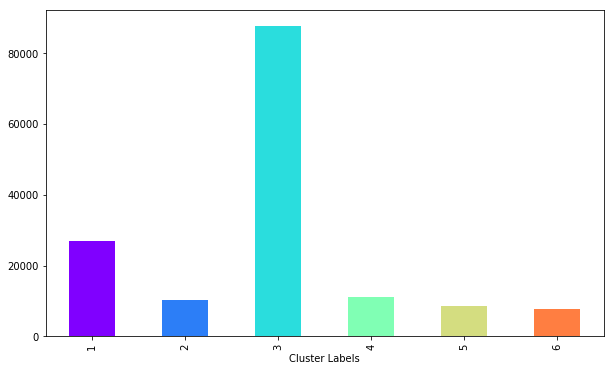

In [112]:
PpC = Santander_combined.groupby("Cluster Labels").POBLACION.sum()
PpC.drop(0, axis=0, inplace=True)
PpC.plot(kind="bar", figsize=(10,6), color = rainbow)
plt.savefig("PopulationPerCluster.png")